# Pattern Recognition Project

In [1]:
%matplotlib inline

import os
import tarfile
import shutil
import hashlib
import glob
import random
import pickle
from datetime import datetime
from typing import *

from numba import jit
import requests
from joblib import Parallel, delayed
from pathlib import Path
from PIL import Image, ImageOps
import numpy as np
from sklearn.metrics import *

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette('muted')

## Functions Used

In [2]:
def to_float_array(img: Image.Image) -> np.ndarray:
    return np.array(img).astype(np.float32) / 255.

def to_image(values: np.ndarray) -> Image.Image:
    return Image.fromarray(np.uint8(values * 255.))

def gamma(values: np.ndarray, coeff: float=2.2) -> np.ndarray:
    return values**(1./coeff)

def gleam(values: np.ndarray) -> np.ndarray:
    return np.sum(gamma(values), axis=2) / values.shape[2]

def to_integral(img: np.ndarray) -> np.ndarray:
    integral = np.cumsum(np.cumsum(img, axis=0), axis=1)
    return np.pad(integral, (1, 1), 'constant', constant_values=(0, 0))[:-1, :-1]

In [3]:
class Box:
    def __init__(self, x: int, y: int, width: int, height: int):
        self.coords_x = [x, x + width, x,          x + width]
        self.coords_y = [y, y,         y + height, y + height]
        self.coeffs   = [1, -1,        -1,         1]
    
    def __call__(self, integral_image: np.ndarray) -> float:
        return np.sum(np.multiply(integral_image[self.coords_y, self.coords_x], self.coeffs))

## Input Data

We give the link to the directory where the training and test sets are stored and from there, we get the faces and non-faces for the training set

In [4]:
data_dir="C:\\Courses\\ECEN649\\Project\\dataset"
train_data_dir=os.path.join(data_dir,"trainset")
train_faces=os.path.join(train_data_dir,"faces")
train_non_faces=os.path.join(train_data_dir,"non-faces")

We find the number of samples for the faces and non-faces in the training data set

In [5]:
face_image_files = glob.glob(os.path.join(train_faces, '**', '*.png'), recursive=True)
len(face_image_files)

499

In [6]:
background_image_files=glob.glob(os.path.join(train_non_faces, '**', '*.png'), recursive=True)
len(background_image_files)

2000

The pictures in the data set are 19×19. While the standard samples in Viola-Jones paper are 24×24, we adjust the window size based on the size of pictures we have

In [7]:
WINDOW_SIZE=19

We use the antialiasing on the image. This step may not be required as it doesn't add much value to the code, but was performed as a test.

In [8]:
def open_face(path: str, resize: bool=True) -> Image.Image:
    
    img = Image.open(path)
    img = to_image(gamma(to_float_array(img)[:, :]))
    min_size = np.min(img.size)
    img = ImageOps.fit(img, (min_size, min_size), Image.ANTIALIAS)
    if resize:
        img = img.resize((WINDOW_SIZE, WINDOW_SIZE), Image.ANTIALIAS)
    return img.convert('L')

We stitch the images together just to make a sense of this

In [9]:
def merge_images(files: Iterable[str], open_fun: Callable, resize: bool=False) -> Image.Image:
    images = [open_fun(f, resize) for f in files]
    sizes = [img.size for img in images]
    collage_width = np.sum([size[0] for size in sizes])
    collage_height = np.max([size[1] for size in sizes])

    result = Image.new('L', (collage_width, collage_height))
    x_offset = 0
    for img, size in zip(images, sizes):
        result.paste(im=img, box=(x_offset, 0))
        x_offset += size[0]
    return result

In [10]:
random.seed(1000)
random_face_files = random.sample(face_image_files, 5)
merge_images(random_face_files, open_face)

We do the same process for the background

In [11]:
def random_crop(img: Image.Image) -> Image.Image:
    max_allowed_size = np.min(img.size)
    size = random.randint(WINDOW_SIZE, max_allowed_size)
    max_width = img.size[0] - size - 1
    max_height = img.size[1] - size - 1
    left = 0 if (max_width <= 1)  else random.randint(0, max_width)
    top  = 0 if (max_height <= 1) else random.randint(0, max_height)
    return img.crop((left,top,left+size,top+size))

def open_background(path: str, resize: bool=True) -> Image.Image:
    img = Image.open(path)
    #img = to_image(gleam(to_float_array(img)))
    img = random_crop(img)
    if resize:
        img = img.resize((WINDOW_SIZE, WINDOW_SIZE), Image.ANTIALIAS)
    return img.convert('L')

In [12]:
random.seed(1000)
random_background_files = random.sample(background_image_files, 5)
merge_images(random_background_files, open_background)

## Training the Classifier

Before we can start the training process, we need to define the features in a way they can actually be evaluated. For this we're going to construct a class for each feature type and then parameterize it according to all possible values, yielding about 160k instances. The best features will be picked later by exhaustive search.

In [13]:
class Feature:
    def __init__(self, x: int, y: int, width: int, height: int):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
    
    def __call__(self, integral_image: np.ndarray) -> float:
        try:
            return np.sum(np.multiply(integral_image[self.coords_y, self.coords_x], self.coeffs))
        except IndexError as e:
            raise IndexError(str(e) + ' in ' + str(self))
    
    def __repr__(self):
        return f'{self.__class__.__name__}(x={self.x}, y={self.y}, width={self.width}, height={self.height})'

With this base class we can define our features:

In [14]:
class Feature2h(Feature):
    def __init__(self, x: int, y: int, width: int, height: int):
        super().__init__(x, y, width, height)
        hw = width // 2
        self.coords_x = [x,      x + hw,     x,          x + hw,
                         x + hw, x + width,  x + hw,     x + width]
        self.coords_y = [y,      y,          y + height, y + height,
                         y,      y,          y + height, y + height]
        self.coeffs   = [1,     -1,         -1,          1,
                         -1,     1,          1,         -1]

In [15]:
class Feature2v(Feature):
    def __init__(self, x: int, y: int, width: int, height: int):
        super().__init__(x, y, width, height)
        hh = height // 2        
        self.coords_x = [x,      x + width,  x,          x + width,
                         x,      x + width,  x,          x + width]
        self.coords_y = [y,      y,          y + hh,     y + hh,
                         y + hh, y + hh,     y + height, y + height]
        self.coeffs   = [-1,     1,          1,         -1,
                         1,     -1,         -1,          1]

In [16]:
class Feature3h(Feature):
    def __init__(self, x: int, y: int, width: int, height: int):
        super().__init__(x, y, width, height)
        tw = width // 3
        self.coords_x = [x,        x + tw,    x,          x + tw,
                         x + tw,   x + 2*tw,  x + tw,     x + 2*tw,
                         x + 2*tw, x + width, x + 2*tw,   x + width]
        self.coords_y = [y,        y,         y + height, y + height,
                         y,        y,         y + height, y + height,
                         y,        y,         y + height, y + height]
        self.coeffs   = [-1,       1,         1,         -1,
                          1,      -1,        -1,          1,
                         -1,       1,         1,         -1]

In [17]:
class Feature3v(Feature):
    def __init__(self, x: int, y: int, width: int, height: int):
        super().__init__(x, y, width, height)
        th = height // 3
        self.coords_x = [x,        x + width,  x,          x + width,
                         x,        x + width,  x,          x + width,
                         x,        x + width,  x,          x + width]
        self.coords_y = [y,        y,          y + th,     y + th,
                         y + th,   y + th,     y + 2*th,   y + 2*th,
                         y + 2*th, y + 2*th,   y + height, y + height]
        self.coeffs   = [-1,        1,         1,         -1,
                          1,       -1,        -1,          1,
                         -1,        1,         1,         -1]

In [18]:
class Feature4(Feature):
    def __init__(self, x: int, y: int, width: int, height: int):
        super().__init__(x, y, width, height)
        hw = width // 2
        hh = height // 2
        self.coords_x = [x,      x + hw,     x,          x + hw,     # upper row
                         x + hw, x + width,  x + hw,     x + width,
                         x,      x + hw,     x,          x + hw,     # lower row
                         x + hw, x + width,  x + hw,     x + width]
        self.coords_y = [y,      y,          y + hh,     y + hh,     # upper row
                         y,      y,          y + hh,     y + hh,
                         y + hh, y + hh,     y + height, y + height, # lower row
                         y + hh, y + hh,     y + height, y + height]
        self.coeffs   = [1,     -1,         -1,          1,          # upper row
                         -1,     1,          1,         -1,
                         -1,     1,          1,         -1,          # lower row
                          1,    -1,         -1,          1]

In [19]:
Feature4(0, 0, 2, 2)(to_integral(np.array([[0, 1], 
                                           [1, 0]])))

-2

We will now instantiate the feature detectors.

In [20]:
Size = NamedTuple('Size', [('height', int), ('width', int)])
Location = NamedTuple('Location', [('top', int), ('left', int)])

def possible_position(size: int, window_size: int = WINDOW_SIZE) -> Iterable[int]:
    return range(0, window_size - size + 1)

def possible_locations(base_shape: Size, window_size: int = WINDOW_SIZE) -> Iterable[Location]:
    return (Location(left=x, top=y)
            for x in possible_position(base_shape.width, window_size) 
            for y in possible_position(base_shape.height, window_size))

def possible_shapes(base_shape: Size, window_size: int = WINDOW_SIZE) -> Iterable[Size]:
    base_height = base_shape.height
    base_width = base_shape.width
    return (Size(height=height, width=width)
            for width in range(base_width, window_size + 1, base_width)
            for height in range(base_height, window_size + 1, base_height))

We can instantiate all possible shapes of the feature:

In [21]:
feature2h = list(Feature2h(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes(Size(height=1, width=2), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

feature2v = list(Feature2v(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes(Size(height=2, width=1), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

feature3h = list(Feature3h(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes(Size(height=1, width=3), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

feature3v = list(Feature3v(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes(Size(height=3, width=1), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

feature4  = list(Feature4(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes(Size(height=2, width=2), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

features = feature2h + feature2v + feature3h + feature3v + feature4

print(f'Number of feature2h features: {len(feature2h)}')
print(f'Number of feature2v features: {len(feature2v)}')
print(f'Number of feature3h features: {len(feature3h)}')
print(f'Number of feature3v features: {len(feature3v)}')
print(f'Number of feature4 features:  {len(feature4)}')
print(f'Total number of features:     {len(features)}')

Number of feature2h features: 17100
Number of feature2v features: 17100
Number of feature3h features: 10830
Number of feature3v features: 10830
Number of feature4 features:  8100
Total number of features:     63960


These are the number of features we have obtained. This is our first result.

## Sampling Data

For training, we want to online sample training data. We start by defining a function to sample examples:

In [22]:
def sample_data(p: int, n: int) -> Tuple[np.ndarray, np.ndarray]:
    xs = []
    xs.extend([to_float_array(open_face(f)) for f in random.sample(face_image_files, p)])
    xs.extend([to_float_array(open_background(f)) for f in np.random.choice(background_image_files, n, replace=True)])

    ys = np.hstack([np.ones((p,)), np.zeros((n,))])
    return np.array(xs), ys

In order to compensate for lighting differences, we variance normalize the training data. For this we obtain a sample mean and standard deviation from the training set:

In [23]:
image_samples, _ = sample_data(499, 2000)

sample_mean = image_samples.mean()
sample_std = image_samples.std()
del image_samples

print(f'Sample mean: {sample_mean}, standard deviation: {sample_std}')

Sample mean: 0.47778645157814026, standard deviation: 0.22844739258289337


In [24]:
def normalize(im: np.ndarray, mean: float = sample_mean, std: float = sample_std) -> np.ndarray:
    return (im - mean) / std

def sample_data_normalized(p: int, n: int, mean: float = sample_mean, std: float = sample_std) -> Tuple[np.ndarray, np.ndarray]:
    xs, ys = sample_data(p, n)
    xs = normalize(xs, mean, std)
    return xs, ys

Using normalization, we expect to see approximately zero mean and unit variance:

In [25]:
xs, _ = sample_data_normalized(100, 100)

print(f'Example mean: {xs.mean()}, standard deviation: {xs.std()}')
del xs
del _

Example mean: 0.35005688667297363, standard deviation: 0.9446033835411072


## Adaboost

In [26]:
random.seed(18151210)
np.random.seed(18151210)
xs, ys = sample_data_normalized(499, 2000)

Convert image to integral images

In [27]:
xis = np.array([to_integral(x) for x in xs])
xs.shape, xis.shape

((2499, 19, 19), (2499, 20, 20))

In [28]:
print(to_integral(x) for x in xs)

<generator object <genexpr> at 0x0000022AEC29F0C8>


In order to get a feeling for our dataset sample, here's what the average face looks like:

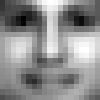

In [29]:
average_face = np.sum(xs[ys > .6], axis=0) / xs[ys > .6].shape[0]
average_face = (average_face - average_face.min()) / (average_face.max() - average_face.min())
to_image(average_face).resize((100, 100))

Here's the same image antialiased.

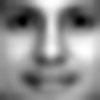

In [30]:
to_image(average_face).resize((100, 100), Image.ANTIALIAS)

Running the same for background, we get the following.

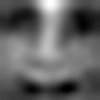

In [31]:
average_background = np.sum(xs[ys < .6], axis=0) / xs[ys < .6].shape[0]
average_background = (average_background - average_background.min()) / (average_background.max() - average_background.min())
to_image(average_background).resize((100, 100), Image.ANTIALIAS)

We also define some helper types to use later.

In [32]:
ThresholdPolarity = NamedTuple('ThresholdPolarity', [('threshold', float), ('polarity', float)])

ClassifierResult = NamedTuple('ClassifierResult', [('threshold', float), ('polarity', int), 
                                                   ('classification_error', float),
                                                   ('classifier', Callable[[np.ndarray], float])])

WeakClassifier = NamedTuple('WeakClassifier', [('threshold', float), ('polarity', int), 
                                               ('alpha', float), 
                                               ('classifier', Callable[[np.ndarray], float])])

Adaboost turns weak learners to strong learners. Here, we define the function for weak learners.

In [33]:
@jit
def weak_classifier(x: np.ndarray, f: Feature, polarity: float, theta: float) -> float:
    # return 1. if (polarity * f(x)) < (polarity * theta) else 0.
    return (np.sign((polarity * theta) - (polarity * f(x))) + 1) // 2

@jit
def run_weak_classifier(x: np.ndarray, c: WeakClassifier) -> float:
    return weak_classifier(x=x, f=c.classifier, polarity=c.polarity, theta=c.threshold)

In [34]:
@jit
def strong_classifier(x: np.ndarray, weak_classifiers: List[WeakClassifier]) -> int:
    sum_hypotheses = 0.
    sum_alphas = 0.
    for c in weak_classifiers:
        sum_hypotheses += c.alpha * run_weak_classifier(x, c)
        sum_alphas += c.alpha
    return 1 if (sum_hypotheses >= .5*sum_alphas) else 0

We regularly need to renomarlize the input weights to obtain a probability distribution:

In [35]:
def normalize_weights(w: np.ndarray) -> np.ndarray:
    return w / w.sum()

We also define the best threshold and polarity.
We have changed the threshold from 0.5 to 0.6 here and have adjusted the same to other places.

In [36]:
@jit
def build_running_sums(ys: np.ndarray, ws: np.ndarray) -> Tuple[float, float, List[float], List[float]]:
    s_minus, s_plus = 0., 0.
    t_minus, t_plus = 0., 0.
    s_minuses, s_pluses = [], []
    
    for y, w in zip(ys, ws):
        if y < .6:
            s_minus += w
            t_minus += w
        else:
            s_plus += w
            t_plus += w
        s_minuses.append(s_minus)
        s_pluses.append(s_plus)
    return t_minus, t_plus, s_minuses, s_pluses


@jit
def find_best_threshold(zs: np.ndarray, t_minus: float, t_plus: float, s_minuses: List[float], s_pluses: List[float]) -> ThresholdPolarity:
    min_e = float('inf')
    min_z, polarity = 0, 0
    for z, s_m, s_p in zip(zs, s_minuses, s_pluses):
        error_1 = s_p + (t_minus - s_m)
        error_2 = s_m + (t_plus - s_p)
        if error_1 < min_e:
            min_e = error_1
            min_z = z
            polarity = -1
        elif error_2 < min_e:
            min_e = error_2
            min_z = z
            polarity = 1
    return ThresholdPolarity(threshold=min_z, polarity=polarity)


def determine_threshold_polarity(ys: np.ndarray, ws: np.ndarray, zs: np.ndarray) -> ThresholdPolarity:  
    # Sort according to score
    p = np.argsort(zs)
    zs, ys, ws = zs[p], ys[p], ws[p]
    
    # Determine the best threshold: build running sums
    t_minus, t_plus, s_minuses, s_pluses = build_running_sums(ys, ws)
    
    # Determine the best threshold: select optimal threshold.
    return find_best_threshold(zs, t_minus, t_plus, s_minuses, s_pluses)

With this, we can determine the weighted error alongside the best threshold and polarity for a feature:

In [37]:
def apply_feature(f: Feature, xis: np.ndarray, ys: np.ndarray, ws: np.ndarray, parallel: Optional[Parallel] = None) -> ClassifierResult:   
    if parallel is None:
        parallel = Parallel(n_jobs=-1, backend='threading')
    
    # Determine all feature values
    zs = np.array(parallel(delayed(f)(x) for x in xis))
    
    # Determine the best threshold
    result = determine_threshold_polarity(ys, ws, zs)
            
    # Determine the classification error
    classification_error = 0.
    for x, y, w in zip(xis, ys, ws):
        h = weak_classifier(x, f, result.polarity, result.threshold)
        classification_error += w * np.abs(h - y)
            
    return ClassifierResult(threshold=result.threshold, polarity=result.polarity, 
                            classification_error=classification_error, classifier=f)

In [38]:
STATUS_EVERY     = 2000
KEEP_PROBABILITY = 1./4.

def build_weak_classifiers(prefix: str, num_features: int, xis: np.ndarray, ys: np.ndarray, features: List[Feature], ws: Optional[np.ndarray] = None) -> Tuple[List[WeakClassifier], List[float]]:
    if ws is None:
        m = len(ys[ys < .6])  # number of negative example
        l = len(ys[ys > .6])  # number of positive examples

        # Initialize the weights
        ws = np.zeros_like(ys)
        ws[ys < .6] = 1./(2.*m)
        ws[ys > .6] = 1./(2.*l)
    
    # Keep track of the history of the example weights.
    w_history = [ws]

    total_start_time = datetime.now()
    with Parallel(n_jobs=-1, backend='threading') as parallel:
        weak_classifiers = []  # type: List[WeakClassifier]
        for t in range(num_features):
            print(f'Building weak classifier {t+1}/{num_features} ...')
            start_time = datetime.now()
            
            # Normalize the weights
            ws = normalize_weights(ws)
            
            status_counter = STATUS_EVERY

            # Select best weak classifier for this round
            best = ClassifierResult(polarity=0, threshold=0, classification_error=float('inf'), classifier=None)
            for i, f in enumerate(features):
                status_counter -= 1
                improved = False

                # Python runs singlethreaded. To speed things up,
                # we're only anticipating every other feature, give or take.
                if KEEP_PROBABILITY < 1.:
                    skip_probability = np.random.random()
                    if skip_probability > KEEP_PROBABILITY:
                        continue

                result = apply_feature(f, xis, ys, ws, parallel)
                if result.classification_error < best.classification_error:
                    improved = True
                    best = result

                # Print status every couple of iterations.
                if improved or status_counter == 0:
                    current_time = datetime.now()
                    duration = current_time - start_time
                    total_duration = current_time - total_start_time
                    status_counter = STATUS_EVERY
                    if improved:
                        print(f't={t+1}/{num_features} {total_duration.total_seconds():.2f}s ({duration.total_seconds():.2f}s in this stage) {i+1}/{len(features)} {100*i/len(features):.2f}% evaluated. Classification error improved to {best.classification_error:.5f} using {str(best.classifier)} ...')
                    else:
                        print(f't={t+1}/{num_features} {total_duration.total_seconds():.2f}s ({duration.total_seconds():.2f}s in this stage) {i+1}/{len(features)} {100*i/len(features):.2f}% evaluated.')

            # After the best classifier was found, determine alpha
            beta = best.classification_error / (1 - best.classification_error)
            alpha = np.log(1. / beta)
            
            # Build the weak classifier
            classifier = WeakClassifier(threshold=best.threshold, polarity=best.polarity, classifier=best.classifier, alpha=alpha)
            
            # Update the weights for misclassified examples
            for i, (x, y) in enumerate(zip(xis, ys)):
                h = run_weak_classifier(x, classifier)
                e = np.abs(h - y)
                ws[i] = ws[i] * np.power(beta, 1-e)
                
            # Register this weak classifier           
            weak_classifiers.append(classifier)
            w_history.append(ws)
        
            pickle.dump(classifier, open(f'{prefix}-weak-learner-{t+1}-of-{num_features}.pickle', 'wb'))
    
    print(f'Done building {num_features} weak classifiers.')
    return weak_classifiers, w_history

In [39]:
random.seed(1337)
np.random.seed(1337)
test_xs, test_ys = sample_data_normalized(499, 2000)
test_xis = np.array([to_integral(x) for x in test_xs])

In [41]:
assert xis.shape[1:3] == (WINDOW_SIZE+1, WINDOW_SIZE+1), xis.shape
weak_classifiers_3, w_history = build_weak_classifiers('3rd', 5, xis, ys, features)

Building weak classifier 1/5 ...
t=1/5 0.68s (0.68s in this stage) 5/63960 0.01% evaluated. Classification error improved to 0.29056 using Feature2h(x=0, y=4, width=2, height=1) ...
t=1/5 23.00s (23.00s in this stage) 104/63960 0.16% evaluated. Classification error improved to 0.23315 using Feature2h(x=5, y=8, width=2, height=1) ...
t=1/5 32.37s (32.37s in this stage) 158/63960 0.25% evaluated. Classification error improved to 0.20190 using Feature2h(x=8, y=5, width=2, height=1) ...
t=1/5 93.43s (93.43s in this stage) 490/63960 0.76% evaluated. Classification error improved to 0.18037 using Feature2h(x=8, y=3, width=2, height=2) ...
t=1/5 261.54s (261.54s in this stage) 1385/63960 2.16% evaluated. Classification error improved to 0.17734 using Feature2h(x=8, y=4, width=2, height=5) ...
t=1/5 350.98s (350.98s in this stage) 1891/63960 2.95% evaluated. Classification error improved to 0.16758 using Feature2h(x=8, y=4, width=2, height=7) ...
t=1/5 434.32s (434.32s in this stage) 2324/6396

<ipython-input-33-e47a16af2a40>:6: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "run_weak_classifier" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at <ipython-input-33-e47a16af2a40> (8)

File "<ipython-input-33-e47a16af2a40>", line 8:
def run_weak_classifier(x: np.ndarray, c: WeakClassifier) -> float:
    return weak_classifier(x=x, f=c.classifier, polarity=c.polarity, theta=c.threshold)
    ^

  @jit
C:\Users\redma\Anaconda3\lib\site-packages\numba\compiler.py:742: NumbaWarning: Function "run_weak_classifier" was compiled in object mode without forceobj=True.

File "<ipython-input-33-e47a16af2a40>", line 7:
@jit
def run_weak_classifier(x: np.ndarray, c: WeakClassifier) -> float:
^

  self.func_ir.loc))
C:\Users\redma\Anaconda3\lib\site-packages\numba\compiler.py:751: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected

Building weak classifier 2/5 ...
t=2/5 12013.84s (0.80s in this stage) 3/63960 0.00% evaluated. Classification error improved to 0.33800 using Feature2h(x=0, y=2, width=2, height=1) ...
t=2/5 12014.68s (1.64s in this stage) 4/63960 0.00% evaluated. Classification error improved to 0.29656 using Feature2h(x=0, y=3, width=2, height=1) ...
t=2/5 12016.30s (3.26s in this stage) 9/63960 0.01% evaluated. Classification error improved to 0.28542 using Feature2h(x=0, y=8, width=2, height=1) ...
t=2/5 12031.94s (18.90s in this stage) 107/63960 0.17% evaluated. Classification error improved to 0.28504 using Feature2h(x=5, y=11, width=2, height=1) ...
t=2/5 12045.26s (32.22s in this stage) 157/63960 0.24% evaluated. Classification error improved to 0.19752 using Feature2h(x=8, y=4, width=2, height=1) ...
t=2/5 12118.43s (105.39s in this stage) 491/63960 0.77% evaluated. Classification error improved to 0.19033 using Feature2h(x=8, y=4, width=2, height=2) ...
t=2/5 12392.41s (379.37s in this stage

In [42]:
weak_classifiers_3

[WeakClassifier(threshold=-34.94171142578125, polarity=1, alpha=2.3535240166187434, classifier=Feature3v(x=0, y=7, width=19, height=12)),
 WeakClassifier(threshold=-1.3389663696289062, polarity=1, alpha=1.5415739225706282, classifier=Feature2h(x=8, y=3, width=2, height=8)),
 WeakClassifier(threshold=0.9956474304199219, polarity=-1, alpha=1.3621383392395696, classifier=Feature2v(x=7, y=11, width=5, height=2)),
 WeakClassifier(threshold=-2.0256080627441406, polarity=1, alpha=1.240216739953939, classifier=Feature2h(x=10, y=8, width=8, height=4)),
 WeakClassifier(threshold=-1.0986175537109375, polarity=1, alpha=1.2664070651570087, classifier=Feature4(x=12, y=14, width=6, height=4))]

## Test Case

In [43]:
test_data_dir=os.path.join(data_dir,"testset")
test_faces=os.path.join(test_data_dir,"faces")
test_non_faces=os.path.join(test_data_dir,"non-faces")

In [44]:
face_image_files_test = glob.glob(os.path.join(test_faces, '**', '*.png'), recursive=True)
len(face_image_files_test)

472

In [45]:
background_image_files_test=glob.glob(os.path.join(test_non_faces, '**', '*.png'), recursive=True)
len(background_image_files_test)

2001

In [46]:
random.seed(1000)
random_face_files_test = random.sample(face_image_files_test, 5)
merge_images(random_face_files_test, open_face)

In [47]:
random.seed(1000)
random_background_files_test = random.sample(background_image_files_test, 5)
merge_images(random_background_files_test, open_background)

In [48]:
def sample_data_test(p: int, n: int) -> Tuple[np.ndarray, np.ndarray]:
    xs = []
    xs.extend([to_float_array(open_face(f)) for f in random.sample(face_image_files_test, p)])
    xs.extend([to_float_array(open_background(f)) for f in np.random.choice(background_image_files_test, n, replace=True)])

    ys = np.hstack([np.ones((p,)), np.zeros((n,))])
    return np.array(xs), ys

In [49]:
image_samples_test, _ = sample_data_test(100, 100)

sample_mean = image_samples_test.mean()
sample_std = image_samples_test.std()
del image_samples_test

print(f'Sample mean: {sample_mean}, standard deviation: {sample_std}')

Sample mean: 0.5171371698379517, standard deviation: 0.235338494181633


In [50]:
def normalize_test(im: np.ndarray, mean: float = sample_mean, std: float = sample_std) -> np.ndarray:
    return (im - mean) / std

def sample_data_normalized_test(p: int, n: int, mean: float = sample_mean, std: float = sample_std) -> Tuple[np.ndarray, np.ndarray]:
    xs, ys = sample_data_test(p, n)
    xs = normalize_test(xs, mean, std)
    return xs, ys

In [51]:
xs, _ = sample_data_normalized_test(100, 100)

print(f'Example mean: {xs.mean()}, standard deviation: {xs.std()}')
del xs
del _

Example mean: 0.03398381918668747, standard deviation: 1.0249199867248535


In [52]:
random.seed(18151210)
np.random.seed(18151210)
xs, ys = sample_data_normalized_test(100, 100)

In [53]:
xis = np.array([to_integral(x) for x in xs])
xs.shape, xis.shape

((200, 19, 19), (200, 20, 20))

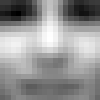

In [54]:
average_face = np.sum(xs[ys > .6], axis=0) / xs[ys > .6].shape[0]
average_face = (average_face - average_face.min()) / (average_face.max() - average_face.min())
to_image(average_face).resize((100, 100))

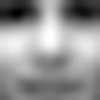

In [55]:
to_image(average_face).resize((100, 100), Image.ANTIALIAS)

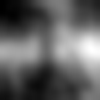

In [56]:
average_background = np.sum(xs[ys < .6], axis=0) / xs[ys < .6].shape[0]
average_background = (average_background - average_background.min()) / (average_background.max() - average_background.min())
to_image(average_background).resize((100, 100), Image.ANTIALIAS)

In [57]:
random.seed(1337)
np.random.seed(1337)
test_xs, test_ys = sample_data_normalized_test(100, 100)
test_xis = np.array([to_integral(x) for x in test_xs])

## Evaluation of the classifier(s)

In [58]:
PredictionStats = NamedTuple('PredictionStats', [('tn', int), ('fp', int), ('fn', int), ('tp', int)])

def prediction_stats(y_true: np.ndarray, y_pred: np.ndarray) -> Tuple[np.ndarray, PredictionStats]:
    c = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = c.ravel()
    return c, PredictionStats(tn=tn, fp=fp, fn=fn, tp=tp)

Precision 0.91, accuracy 0.87, recall 0.82, false positive rate 0.08, false negative rate 0.18.


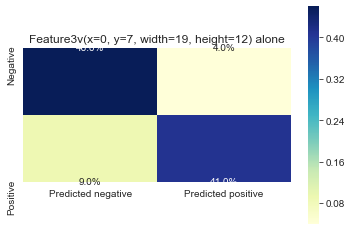

In [64]:
ys_1 = np.array([run_weak_classifier(x, weak_classifiers_3[0]) for x in test_xis])
c, s = prediction_stats(test_ys, ys_1)

sns.heatmap(c / c.sum(), cmap='YlGnBu', annot=True, square=True, fmt='.1%',
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title(f'{weak_classifiers_3[0].classifier} alone');

print(f'Precision {s.tp/(s.tp+s.fp):.2f}, accuracy {(s.tp+s.tn)/(s.tp+s.tn+s.fp+s.fn):.2f}, recall {s.tp/(s.tp+s.fn):.2f}, false positive rate {s.fp/(s.fp+s.tn):.2f}, false negative rate {s.fn/(s.tp+s.fn):.2f}.')

Precision 0.53, accuracy 0.51, recall 0.19, false positive rate 0.17, false negative rate 0.81.


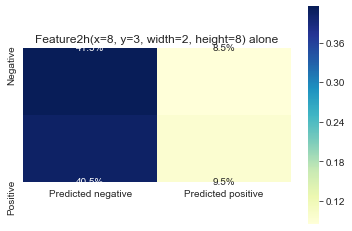

In [65]:
ys_1 = np.array([run_weak_classifier(x, weak_classifiers_3[1]) for x in test_xis])
c, s = prediction_stats(test_ys, ys_1)

sns.heatmap(c / c.sum(), cmap='YlGnBu', annot=True, square=True, fmt='.1%',
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title(f'{weak_classifiers_3[1].classifier} alone');

print(f'Precision {s.tp/(s.tp+s.fp):.2f}, accuracy {(s.tp+s.tn)/(s.tp+s.tn+s.fp+s.fn):.2f}, recall {s.tp/(s.tp+s.fn):.2f}, false positive rate {s.fp/(s.fp+s.tn):.2f}, false negative rate {s.fn/(s.tp+s.fn):.2f}.')

Precision 0.93, accuracy 0.56, recall 0.13, false positive rate 0.01, false negative rate 0.87.


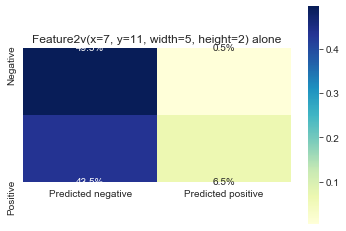

In [66]:
ys_1 = np.array([run_weak_classifier(x, weak_classifiers_3[2]) for x in test_xis])
c, s = prediction_stats(test_ys, ys_1)

sns.heatmap(c / c.sum(), cmap='YlGnBu', annot=True, square=True, fmt='.1%',
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title(f'{weak_classifiers_3[2].classifier} alone');

print(f'Precision {s.tp/(s.tp+s.fp):.2f}, accuracy {(s.tp+s.tn)/(s.tp+s.tn+s.fp+s.fn):.2f}, recall {s.tp/(s.tp+s.fn):.2f}, false positive rate {s.fp/(s.fp+s.tn):.2f}, false negative rate {s.fn/(s.tp+s.fn):.2f}.')

Precision 0.60, accuracy 0.57, recall 0.46, false positive rate 0.31, false negative rate 0.54.


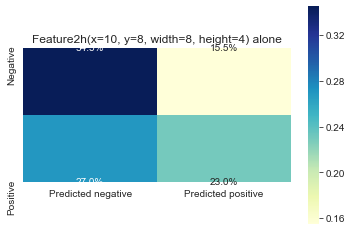

In [67]:
ys_1 = np.array([run_weak_classifier(x, weak_classifiers_3[3]) for x in test_xis])
c, s = prediction_stats(test_ys, ys_1)

sns.heatmap(c / c.sum(), cmap='YlGnBu', annot=True, square=True, fmt='.1%',
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title(f'{weak_classifiers_3[3].classifier} alone');

print(f'Precision {s.tp/(s.tp+s.fp):.2f}, accuracy {(s.tp+s.tn)/(s.tp+s.tn+s.fp+s.fn):.2f}, recall {s.tp/(s.tp+s.fn):.2f}, false positive rate {s.fp/(s.fp+s.tn):.2f}, false negative rate {s.fn/(s.tp+s.fn):.2f}.')

Precision 0.50, accuracy 0.50, recall 0.11, false positive rate 0.11, false negative rate 0.89.


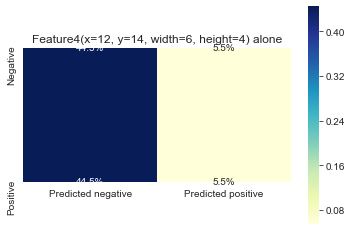

In [68]:
ys_1 = np.array([run_weak_classifier(x, weak_classifiers_3[4]) for x in test_xis])
c, s = prediction_stats(test_ys, ys_1)

sns.heatmap(c / c.sum(), cmap='YlGnBu', annot=True, square=True, fmt='.1%',
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title(f'{weak_classifiers_3[4].classifier} alone');

print(f'Precision {s.tp/(s.tp+s.fp):.2f}, accuracy {(s.tp+s.tn)/(s.tp+s.tn+s.fp+s.fn):.2f}, recall {s.tp/(s.tp+s.fn):.2f}, false positive rate {s.fp/(s.fp+s.tn):.2f}, false negative rate {s.fn/(s.tp+s.fn):.2f}.')

<ipython-input-34-886b5b384fd2>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "strong_classifier" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at <ipython-input-34-886b5b384fd2> (3)

File "<ipython-input-34-886b5b384fd2>", line 3:
def strong_classifier(x: np.ndarray, weak_classifiers: List[WeakClassifier]) -> int:
    sum_hypotheses = 0.
    ^

  @jit
<ipython-input-34-886b5b384fd2>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "strong_classifier" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "<ipython-input-34-886b5b384fd2>", line 5:
def strong_classifier(x: np.ndarray, weak_classifiers: List[WeakClassifier]) -> int:
    <source elided>
    sum_alphas = 0.
    for c in weak_classifiers:
    ^

  @jit
C:\Users\redma\Anaconda3\lib\site-packages\numba\compiler.py:742: Numba

Precision 0.83, accuracy 0.60, recall 0.25, false positive rate 0.05, false negative rate 0.75.


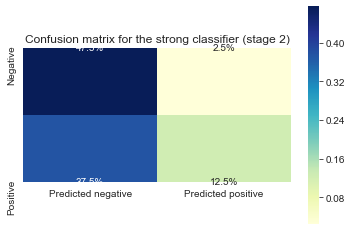

In [69]:
ys_strong = np.array([strong_classifier(x, weak_classifiers_3) for x in test_xis])
c, s = prediction_stats(test_ys, ys_strong)

sns.heatmap(c / c.sum(), cmap='YlGnBu', annot=True, square=True, fmt='.1%',
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion matrix for the strong classifier (stage 2)');

print(f'Precision {s.tp/(s.tp+s.fp):.2f}, accuracy {(s.tp+s.tn)/(s.tp+s.tn+s.fp+s.fn):.2f}, recall {s.tp/(s.tp+s.fn):.2f}, false positive rate {s.fp/(s.fp+s.tn):.2f}, false negative rate {s.fn/(s.tp+s.fn):.2f}.')